## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import sys
import os
from filterpy.monte_carlo import systematic_resample
import scipy as sp
from scipy import stats
from sklearn import preprocessing

PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.dirname('utils'), 
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)
from filterscripts import distance_map
%matplotlib inline

## Erstellen der Distance Map
Die Distance-Map ist eine representation der Karte, auf der das Auto fährt. Diese Karte enthält Informationen über die Referenzlinien der jeweiligen Straßen. Jeder Pixel der Distance Map enthält dabei einen Wert zwischen 0 und 1 und gibt darüber an, wie weit er von dem am nächsten liegenden Straßenpunkt entfernt ist. Für den Umgang mit der Distance Map war es notwendig ein 2D-Array zu erzeugen, dass ein Abbild der Karte darstellt. Dieses Array wird genutzt, um die Distance Map und auch die Karte als Bild zu speichern. Allerdings brauchte es hier eine Möglichkeit, zwischen den Koordinaten dieses Arrays und den Koordinaten aus der Simulation umzurechnen. Die Distance Map wurde also folgendermaßen erzeugt: 
### Festlegen der gewünschten Genauigkeit
Die einzelnen Straßenpunkte sind in einer Liste gespeichert. Über den Wert 

    decimal_places
    
wird angegeben, wie viele diesert Nachkommastellen miteinbezogen werden und dementsprechend wie hoch aufgelöst die Distance Map schlussendlich ist. Anschließend werden zwei Werte festgelegt, die zwischen den Koordinaten der SImulation (die auch Nachkommastellen haben) und den ganzzahligen Koordinaten des Image-Arrays umrechnen können. Diese sehen wie folgt aus: 

    to_array_indices = 10**decimal_places
    to_coordinates = 10**-decimal_places

### Konvertierung der Straßenpunkte
Die Straßenpunkte wurden bereits aus der Karten-Datei der Simulation extrahiert und mittels parametrischer Funktionen berechnet. Sie werden geladen und anschließend mit den erzeugten Variablen in das Koordinatensystems des Image-Arrays überführt. 

### Erzeugen des Image Arrays
Das Image Array muss auf Basis der Straßenpunkte erzeigt werden. Dementsprechend mussten hier die Maximal- und Minimalwerte für die x- und y-Koordinaten berechnet werden. Außerdem wurde das Image Array mit einem zusätzlichen rand versehen. Auf Basis dieser Werte konnte das Image Array (oder auch Map Array geneannt) erzeugt werden.

    x_min_bound = self.road_point_indicies[:,0].min() - additional_border
    y_min_bound = self.road_point_indicies[:,1].min() - additional_border
    x_max_bound = self.road_point_indicies[:,0].max() + additional_border
    y_max_bound = self.road_point_indicies[:,1].max() + additional_border
    size_x = int(self.x_max_bound - self.x_min_bound)
    size_y = int(self.y_max_bound - self.y_min_bound)
    map_array = np.zeros((self.y_max_bound + (0 - self.y_min_bound), self.x_max_bound + (0 -self.x_min_bound)), np.uint8)

Zuerst wird dieses Distance Map erzeugt und geplotted:

Converted Points (135, 2)
(2595, 2740)


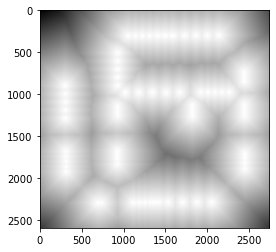

In [2]:
dm = distance_map.DistanceMap(1, 300, 'road_points_data_test')
plt.imshow(dm.distance_map, cmap="gray")

# Particle Filter 
In diesem Abschnitt wird der Partikelfilter erstellt. Zuerst wird eine Funktion benötigt, die Partikel auf der Karte erzeugt. Diese werden dann später mit jeder Iteration angepasst und versuchen, den wahren Zustand des Systems immer besser abzubilden. Für die initiale Erstellung der Partikel gibt es zwei herangehensweisen. Die erste erzeugt sie Uniform auf der gesamten Karte. Die zweite erzeugt sie um einen Durschnittswert normalverteilt. 

Ich habe beide implementiert. Variante 1 würde dann zum Einsatz kommen, wenn es keine initialie Information gibt, wo sich das Auto zu Beginn befindet. Variante 2 würde dann zum Einsatz kommen, wenn ein sehr ungenaues initiales GPS Signal Aufschluss über die anfängliche Position gibt, bzw. diese stark eingrenzt. 

## Variante 1 - Uniforme Partikel

In [3]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, x_dot_range, y_dot_range,x_ddot_range, y_ddot_range, theta_range, delta_range,N):
    particles = np.empty((N, 8))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(x_dot_range[0], x_dot_range[1], size=N)
    particles[:, 3] = uniform(y_dot_range[0], y_dot_range[1], size=N)
    particles[:, 4] = uniform(x_ddot_range[0], x_ddot_range[1], size=N)
    particles[:, 5] = uniform(y_ddot_range[0], y_ddot_range[1], size=N)    
    particles[:, 6] = uniform(theta_range[0], theta_range[1], size=N)
    particles[:, 7] = uniform(delta_range[0], delta_range[1], size=N)
    particles[:, 6] %= 2 * np.pi
    particles[:, 7] %= 2 * np.pi
    return particles

## Variant 2 - Gaußverteilte Partikel

In [4]:
from scipy import randn


def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 8))
    particles[:, 0] = mean[0] + randn((N) * std[0])
    particles[:, 1] = mean[1] + randn((N) * std[0])
    particles[:, 2] = mean[2] + randn((N) * std[0])
    particles[:, 3] = mean[3] + randn((N) * std[0])
    particles[:, 4] = mean[4] + randn((N) * std[0])
    particles[:, 5] = mean[5] + randn((N) * std[0])
    particles[:, 6] = mean[6] + randn((N) * std[0])
    particles[:, 7] = mean[7] + randn((N) * std[0])
    particles[:, 6] %= 2 * np.pi
    particles[:, 7] %= 2 * np.pi
    return particles

## Prozessmodell eines Fahrzeugs
Der Vorhersageschritt des Partikelfilters bewegt alle Partikel anhand des Control Inputs entsprechend des Prozessmodells. Hierfür habe ich mich für das Kinematic Front Wheel Bycicle Modell entschieden. 
Dieses ist eine Annäherung an ein Vierrädriges Fahrzeugs und geht nur von zwei Rädern aus. Einem Vorder- und einem Hinterrad. Dabei wird davon ausgegangen, dass sich nur das Vorderrad drehen kann. 

Der Zustand $\vec x$ unseres Systems ist definiert als: 

$$
\vec x = \begin{bmatrix} x, y, \dot x, \dot y, \ddot x , \ddot y, \theta, \delta \end{bmatrix}^T
$$

Der Control Input $\vec u$ ist definiert als: 
$$
\vec u = \begin{bmatrix} \ddot x_u, \ddot y_u, \varphi \end{bmatrix}
$$

Zudem haben wir folgemde Messungen $\vec z$: 
$$
\vec z = \begin{bmatrix} \ddot x_z, \ddot y_z, \theta \end{bmatrix}
$$ 

Die für den Vorhersageschritt verwendete Zustandstransferfunktion sieht folgendermaßen aus:
$$
\vec x_{t+1} = 
\begin{bmatrix} x_{t+1}\\ y_{t+1}\\ \dot x_{t+1}\\
\dot y_{t+1}\\
\ddot x_{t+1}\\
\ddot y_{t+1} \\
\theta_{t+1} \\ 
\delta_{t+1} \\
\end{bmatrix}
=
\begin{bmatrix} 
x_t + v\cos(\theta_t + \delta_t)  \Delta t\\ 
y_t + v\sin(\theta_t + \delta_t)  \Delta t\\ 
\dot x_t + \ddot x_{t} \Delta t\\ 
\dot y_t + \ddot y_{t} \Delta t\\
%\ddot x_t + \dddot x_t \Delta t \\ 
%\ddot y_t + \dddot y_t \Delta t\\ 
\ddot x_{u_t}\\
\ddot y_{u_t}\\
\theta_t + \frac{v\sin(\delta)}{L} \Delta t\\ 
\delta + \varphi \Delta t
\end{bmatrix}$$

In [5]:
# x = x-0,y-1,x_dot-2, y_dot-3, x_ddot-4, y_ddot-5, theta-6, delta-7
# u = acc_x, acc_y, steering 
def F(x, u, step, L, std, N): 
    # calculate nect velocity
    x_dot_next = x[2] + (x[4] * step) 
    y_dot_next = x[3] + (x[5] * step)
    # control input as next acceleration
    x_ddot_next = u[0] + (np.random.uniform(0,1,1) * std[0])
    y_ddot_next = u[1] + (np.random.uniform(0,1,1) * std[1])
    # calculate velocity scalar
    velocity = np.linalg.norm((x[2], x[3]))
    # get next position
    x_next = x[0] + (velocity*np.cos(x[6] + x[7]) * step)
    y_next = x[1] + (velocity*np.sin(x[6] + x[7]) * step)
    #calculate theta and delta
    theta_next = x[6] + (((velocity*np.sin(x[7]))/L) * step)
    delta_next = x[7] + ((u[2] + np.random.uniform(0,1,1)*std[2]) * step)
    
    
    return np.array([x_next, y_next,x_dot_next, y_dot_next, x_ddot_next, y_ddot_next, theta_next, delta_next], dtype=object) 

def predict(particles, u, std, dt, L): 
    N = len(particles) 
    # Needs noise: not in a for loop
    for i in range(len(particles)): 
        particles[i] = F(particles[i], u, dt, L, std, len(particles))

## Der Update-Schritt
Der Update schritt ist dafür verantwortlich, die Gewichte der einzelnen Partikel anzupassen. Hierfür verwendet er die Messungen, die gemacht wurden. Hier muss noch arbeit reinfließen.

In [6]:


def update(particles, weights,z, R, distance_map):
    # use circular mean
    rotation_differences = abs(np.exp(1j*particles[:,6]/180*np.pi) - np.exp(1j*z[2]/180*np.pi))
    #rotation_differences = abs((abs(particles[:,6]-z[2])+180) %360 - 180)# index 6 = theta
    rot_diff_weight = 1 - preprocessing.minmax_scale(rotation_differences)

    acceleration_difference = np.array(list(map(np.linalg.norm, z[0:2] - particles[:,4:5])), dtype=object)
    acc_diff_weight = 1 - preprocessing.minmax_scale(acceleration_difference)

    particles_image_coords = dm.coord_to_image(particles[:, 0:2])
    distances = []
    
    for p in particles_image_coords: 
        if (p[0] < dm.distance_map.shape[1] and p[0] > 0 and p[1] < dm.distance_map.shape[0] and p[1] > 0): 
            distances.append(dm.distance_map[p[1], p[0]])
        else:
            distances.append(np.array(0))
    distances = np.array(distances, dtype=object)
    average_distances = (rot_diff_weight + acc_diff_weight + distances) / 3
    weights = weights * average_distances

    weights += 1.e-300
    
    weights /= sum(weights) # normalize
    
    
def estimate(particles, weights): 
    pos = particles[:,0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var


def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))
    
def neff(weights):
    return 1. / np.sum(np.square(weights))

## Einlesen und bearbeiten der Daten
In diesem Schritt werden die Daten eingelesen. Da das Koordinatensystem der Carla Simulation ein linkshändiges ist, muss die Y-Achse invertiert werden. Zudem muss die Rotation der Beschleunigung in das Welt-Koordinatensystem überführt werden. Hierfür werden mittels der Kompass, den die IMU-Sensoren der Simulation enthalten, die Rotationsmatritzen für jeden Zeitschritt definiert und dann auf die Werte des accelerometer angewandt. Das bezieht sich nämllich auf das Koordinatensystem der IMU-Sensoren.

In [7]:
def get_rotation_matrix(theta): 
    return np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

In [8]:
simulation_data = pd.read_csv("../data/Sim_data_long.csv")
local_acc = np.stack((simulation_data['accelerometer_x'], simulation_data['accelerometer_y']), axis = 1)

matrices = []
for o in simulation_data['orientations'].values: 
    matrices.append(get_rotation_matrix(o))
matrices = np.array(matrices)

global_acc = []
for i in range(len(matrices)): 
    global_acc.append(np.dot(local_acc[i], matrices[i]))
global_acc = np.array(global_acc)

simulation_data['accelerometer_x'] = global_acc[:, 0]
simulation_data['accelerometer_y'] = global_acc[:, 1]
simulation_data['positions_y'] = -simulation_data['positions_y']
simulation_data['acc_y'] = -simulation_data['acc_y']
simulation_data['accelerometer_y'] = -simulation_data['accelerometer_y']
simulation_data['velocity_y'] = -simulation_data['velocity_y']


Invertieren der Y-Axe 

## Plot-Funktion der Ergebnisse
Diese Funktion ist dafür zuständig die Ergebnisse zu plotten.

In [9]:
def plot_particles_and_mean(particles, weights, mu, ground_truth,index): 
    # convert and plot the particles 
    converted_particles = []
    plt.imshow(dm.distance_map, cmap="gray")
    for i, rp in enumerate(particles): 
        converted_particle = dm.coord_to_image(np.array([rp[0], rp[1]]))
        plt.scatter(converted_particle[0], converted_particle[1], s=weights[i]*500, c='blue', alpha=0.5)
    
    #convert and plot mean
    mean = dm.coord_to_image(mu)
    plt.plot(mean[0], mean[1], 'ro')
    
    #convert and plot ground truth
    converted_gt = dm.coord_to_image(ground_truth)
    
    plt.scatter(converted_gt[0],converted_gt[1], c="green")
    #plt.ylim([2500, 0])
    #plt.xlim([0, 2500])
    plt.savefig('../data/images/pfanim/pi_'+str(index)+'.jpg')
    plt.clf()
    #plt.show()

## First test with real data+
This is very important to understand - a very accurate sensor can lead to poor performance of the filter because few of the particles will be a good sample of the probability distribution. There are a few fixes available to us. First, we can artificially increase the sensor noise standard deviation so the particle filter will accept more points as matching the robots probability distribution. This is non-optimal because some of those points will be a poor match. The real problem is that there aren't enough points being generated such that enough are near the robot. Increasing N usually fixes this problem. This decision is not cost free as increasing the number of particles significantly increase the computation time. Still, let's look at the result of using 100,000 particles.

In [12]:
def run_pf_imu(simulation_data, sensor_std, dm, std):

    ground_truth = np.stack([simulation_data['positions_x'], simulation_data['positions_y']], axis=1)
    zs = np.stack([simulation_data['accelerometer_x'], simulation_data['accelerometer_y'], simulation_data['orientations']], axis=1)
    us = np.stack([simulation_data['acc_x'], simulation_data['acc_y'], simulation_data['steering'].values], axis=1)


    seconds = 60
    dt = 1/10
    Ts=simulation_data['timestamps'].values
    xs = []
    L = 1.8
    N = 100

    x_min = dm.road_points[:,0].min()
    x_max = dm.road_points[:,0].max()

    y_min = dm.road_points[:,1].min()
    y_max = dm.road_points[:,1].max()

    x_range = [x_min, x_max]
    y_range = [y_min, y_max]
    x_dot_range = [0, 11]
    y_dot_range = [0, 11]
    x_ddot_range = [0, 10]
    y_ddot_range = [0, 10]

    theta_range = [0,2*np.pi]
    delta_range = [-np.pi/2, np.pi/2]
    particles = create_uniform_particles(x_range, y_range, x_dot_range, y_dot_range,x_ddot_range, y_ddot_range, theta_range, delta_range, N)
    weights = np.full((particles.shape[0],), 1/particles.shape[0])
    std = np.array([0.2, 0.2, 0.2])

  
    for i,u in enumerate(Ts): 

        predict(particles, us[i], std, Ts[i] - Ts[i-1], L)
        #predict(particles, us[i], std, dt, L)
        
        # add noise to measurement (later done in carla?)
        zs[i] += (np.random.randn(len(zs[i]))*sensor_std)

        update(particles, weights, zs[i], 0, dm.distance_map)
        
        if (neff(weights) < N/2): 
            print("resample")
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)

        mu, var = estimate(particles,weights)
        
        xs.append(mu)
    xs = np.array(xs)
    return particles, weights, xs


In [14]:
particles, weights, xs = run_pf_imu(simulation_data, 1.4, dm, np.array([0.2, .2, .2]))

## Plot particles
Legends will be added later: 
- blue = particles
- red = mean
- yellow = ground truth

In [15]:
ground_truth = np.stack([simulation_data['positions_x'], simulation_data['positions_y']], axis=1)


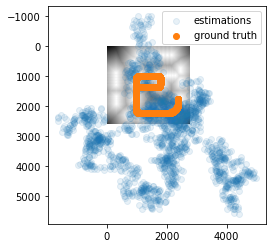

In [16]:
xs_image_coord = []
for x in xs: 
    xs_image_coord.append(dm.coord_to_image(x))
xs_image_coord = np.array(xs_image_coord)

gt_image_coord = []
for gt in ground_truth: 
    gt_image_coord.append(dm.coord_to_image(gt))
gt_image_coord = np.array(gt_image_coord)

plt.imshow(dm.distance_map, cmap="gray")
plt.scatter(xs_image_coord[:,0], xs_image_coord[:,1], label="estimations", alpha = 0.1)
plt.scatter(gt_image_coord[:,0],gt_image_coord[:,1], label="ground truth")
#plt.ylim([2500, 0])
#plt.xlim([0, 2500])
plt.legend()
plt.show()

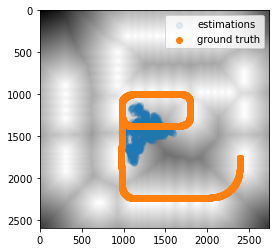

In [36]:

len(particles)

10000